In [2]:
import plotly.express as px
import pandas as pd
from plotly import graph_objects as go
import plotly
import string

In [3]:
sys_turns_path = "../analysis/simmc_furniture/furniture_dev_sys_turns.txt"

In [4]:
with open(sys_turns_path) as file_h:
    sys_turns = file_h.read().splitlines()

sys_turns = pd.Series(sys_turns)

In [6]:
sys_turns

0       Wonderful! Is there a particular style you are...
1       Here is a nice cube storage bookcase in a ches...
2                                             Here ya go!
3                                                   Sure.
4       I only see the only color for this bookcase. W...
                              ...                        
4822            I have this one but it's not solid black.
4823    It measures 33"H x 72" W x 31" D. Do you think...
4824                         This sofa sells for $988.99.
4825    Great, I've added it to your cart... will ther...
4826                                      You're welcome.
Length: 4827, dtype: object

In [5]:
# data cleaning functions

def clean_input_sentences(ser):
    '''
    clean a Series of strings. Modify according to requirement
    
    Right now only removes punctuation
    '''
    ser = ser.apply(lambda x: x[:-1] if x[-1] in string.punctuation else x)
    ser = ser.apply(lambda x: ''.join(['' if s in string.punctuation else s for s in x ]))
    return ser

In [7]:

normans_ls = sys_turns.str.split(' ')

# Create functions for manipulating data and plotting

def expand_sentence(sentence, n ):
    sen = sentence.split(' ')
    dc = {}
    for i in range(n):
        try:
            dc[i] = sen[i]
        except IndexError:
            dc[i] = '<blank>'
    return dc

def expand_sentence_cols(ser, n=2):
    df = ser.apply(expand_sentence,n=n)
    return pd.DataFrame(list(df))

def plot_sentence_sunburst(ser, level=2, clean_input=True, threshold_first_level=0, min_last_level_count=0, filepath = ''):
    """
    ser: pandas series containing sentences as strings with words separated by single space
    level: the depth of sunburst plot in terms of words to be taken from beginning
    output: sunburst plot of words in sentences depicting their connections and frequency
    """
    if clean_input:
        ser = clean_input_sentences(ser)
    
    df = expand_sentence_cols(ser, n=level)
    
    if threshold_first_level:
        threshold_values = list(df[0].value_counts().nlargest(threshold_first_level).index)
        df = df.loc[df[0].map(lambda x: x in threshold_values)]
    
    df = pd.DataFrame(df.groupby(list(range(level))).apply(len)).rename(columns={0:'count'}).reset_index()
    
    if min_last_level_count == 0:
        min_last_level_count = len(ser)/(100*level)
    df = df.query("count >= @min_last_level_count")
    df.replace('','<blank>')
    #return df
    fig = px.sunburst(df, path=list(range(level)), values='count')
    if filepath:
        fig.write_html(filepath)
    fig.show()


In [8]:
def get_layer_data(ser, n=2): # gets data  as value counts from the given layer from event_path # i.e the counts of n-1th and nth steps
    ser_x = ser.str.split(' ').map(lambda x: tuple(x[n-2:n]) if len(x)>=n else None)
    return pd.Series(ser_x).value_counts()
    
def get_all_indices(listlike, compare_value):
    return [i for i, value in enumerate(listlike) if value == compare_value]

# creating a new class from go.Sankey
class Layered_sankey(go.Sankey):
    def add_first_layer(self, data_value_counts): # adds first layer from a value_counts dataframe
        #nodes
        old_labels = list(data_value_counts.index.map(lambda x: x[0]).drop_duplicates())
        updated_labels = list(list(data_value_counts.index.map(lambda x: x[0]).drop_duplicates()) #First Layer, no incoming connections
                          + list(data_value_counts.index.map(lambda x: x[1]).drop_duplicates()) # Second Layer, contains connections from first layer
                         )
        #links
        new_source = [] #getting the sources for links from the first element of indx pair
        new_target = [] #getting the target for links from the second element of indx pair
        new_value = [] #  changed here to avoid duplication
        sum_value = data_value_counts.sum()
        self['node']['label'] = updated_labels
        self['link']['source'] = new_source
        self['link']['target'] = new_target
        self['link']['value'] = new_value
        
        for s, t in data_value_counts.index:
            new_source.append(get_all_indices(old_labels, s)[-1])#appending source 
            new_target.append(get_all_indices(updated_labels, t)[-1])#appending target
            new_value.append(data_value_counts[(s,t)])#appending value
        self['node']['label'] = updated_labels
        self['link']['source'] = new_source
        self['link']['target'] = new_target
        self['link']['value'] = new_value
        self['link']['label'] = tuple(
            map(
                lambda x: str(round(x*100,4)) + ' %', list(data_value_counts/sum_value)
            )
        )

        
 
    
    def add_layer(self,data_value_counts): # adds a layer from value counts dataframe
        #nodes
        old_labels = list(self['node']['label'])
        new_labels = list(data_value_counts.index.map(lambda x: x[1]).drop_duplicates()) # add new layer nodes
        updated_labels = tuple(old_labels + new_labels)
        sum_value = data_value_counts.sum()
        #print (old_labels)
        #print(new_labels)
        #print(updated_labels)
        #links 
        new_source = list(self['link']['source'])
        new_target = list(self['link']['target'])
        new_value = list(self['link']['value'])
        new_label = list(self['link']['label'])
        
        for s, t in data_value_counts.index:
            new_source.append(get_all_indices(old_labels, s)[-1])#appending source 
            new_target.append(get_all_indices(updated_labels, t)[-1])#appending target
            new_value.append(data_value_counts[(s,t)])#appending value
            new_label.append(str(round(100*data_value_counts[(s,t)]/sum_value, 4)) + ' %')#appending label
            
        self['node']['label'] = tuple(updated_labels)
        self['link']['source'] = tuple(new_source)
        self['link']['target'] = tuple(new_target)
        self['link']['value'] = tuple(new_value)
        self['link']['label'] = tuple(new_label)


In [13]:
def plot_sentence_sankey(ser, level=2):
    #initialise the sankey using basic info
    fwd_sankey = Layered_sankey(
        node = dict(
          #pad = 15,
          #thickness = 20,
          #line = dict(color = "black", width = 0.5),
          #label = ["RedZone Purchase"],
          #color = "blue"
        ),
        link = dict(
        color = 'rgba(0,0,150,0.2)' # color of connections
        )
    )
    
    fwd_sankey.add_first_layer(get_layer_data(ser, 2))
    if level > 2:
        for i in range(3, level+1):
            fwd_sankey.add_layer(get_layer_data(ser, i))
    
    fig = go.Figure(data = fwd_sankey)
    fig.show()


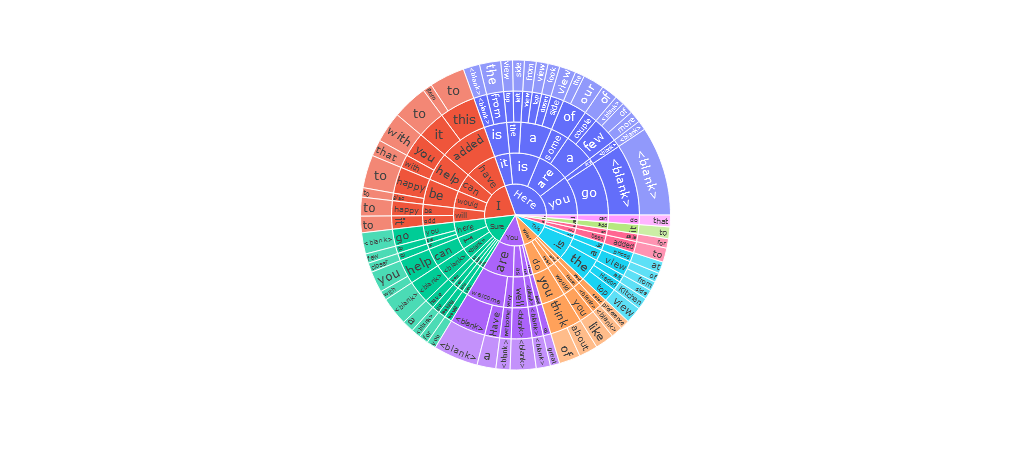

In [133]:
plot_sentence_sunburst(sys_turns, 5,threshold_first_level=10 ,min_last_level_count=4, filepath='a.html')

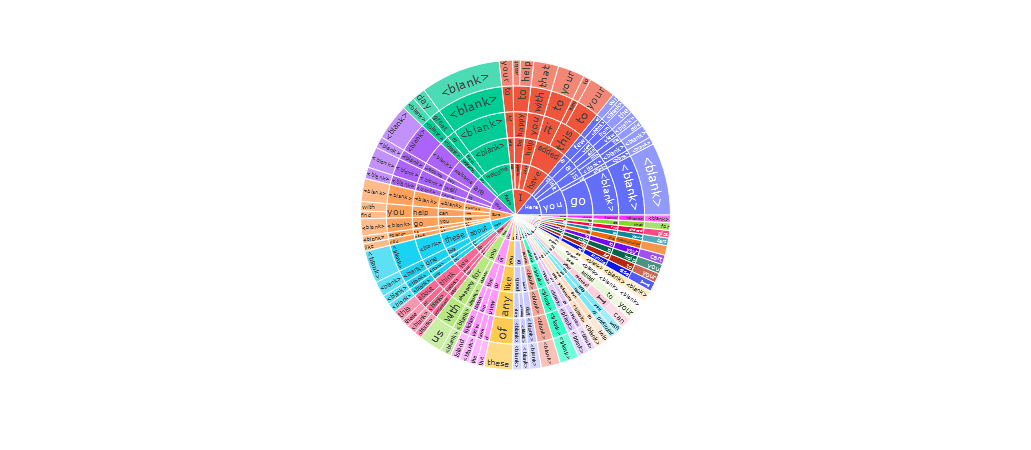

In [10]:
plot_sentence_sunburst(sys_turns, 6
                       ,min_last_level_count=4, filepath='a.html')

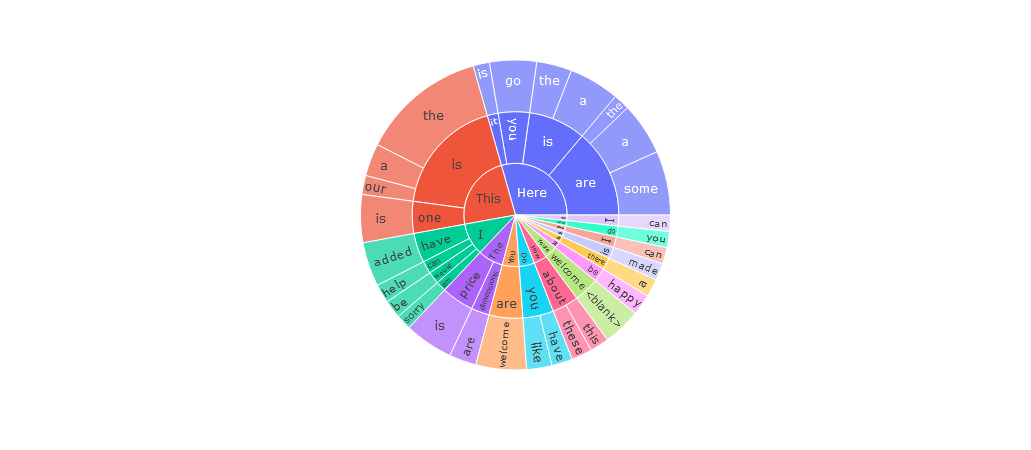

In [12]:
plot_sentence_sunburst(sys_turns, 3)

In [43]:
l = 'abcd'


'acd'